In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
from scipy.interpolate import CubicSpline
import scipy.spatial.transform as sst

In [449]:
def read_input():
    lines = open('results').readlines()
    results = []
    coordinates = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        if parts[0] == '#R':
            q = parts[1].strip('/').split('/')
            row['target'] = q[-2]
            if row['target'] == 'NN-2':
                row['target'] = 'N2-2'
            row['box'] = int(q[-1].split('-')[-1])
            row['energies'] = np.array([float(_) for _ in parts[2:]])
            row['numatoms'] = len(row['energies'])
            results.append(row)
        if parts[0] == '#C':
            numatoms = int(parts[1])
            row['numatoms'] = numatoms
            row['zs'] = [int(float(_)) for _ in parts[2:2+numatoms]]
            row['coords'] = np.array([float(_) for _ in parts[-3*numatoms:]]).reshape(-1, 3)
            coordinates.append(row)
    return pd.DataFrame(results), pd.DataFrame(coordinates)
r, c = read_input()
def read_energies2():
    lines = open('results-energies').readlines()
    energies = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        row['energy'] = float(parts[-2])
        parts = parts[0].split('/')
        row['target'] = parts[0]
        if row['target'] == 'NN-2':
            row['target'] = 'N2-2'
        row['box'] = int(parts[1].split('-')[-1])
        energies.append(row)
    return pd.DataFrame(energies)
def read_energies():
    return pd.merge(read_energies2()['box target'.split()], pd.read_csv('631results-energies', sep=' ', header=None, names='target energy'.split()), on='target')
def get_nuc_nuc_energy():
    def _get_e(row):
        e = np.outer(row.zs, row.zs)/ scs.distance.squareform(scs.distance.pdist(row.coords))
        np.fill_diagonal(e, 0)
        return e.sum(axis=0)/2    
    q = pd.merge(c, r, left_index=True, right_index=True)['coords zs target'.split()].drop_duplicates('target')
    q['enn'] = q.apply(_get_e, axis=1)
    return q['target enn zs'.split()]
    
energy_data = pd.merge(read_energies(), get_nuc_nuc_energy())

# extrapolate for infinite box size (in df as 1000)
# alchemical energies: extrapolation for 1/box size at 0 via linreg
# total energies: already converged at box site 20
rows = []
for name, group in r.sort_values('box').groupby('target'):
    extrapolated = []
    for site in range(group.numatoms.values[0]):
        es = np.array(group.energies.values.tolist())
        #plt.plot(1/group.box, es[:, site], label=name)
        try:
            extrapolated.append(np.polyfit(1/group.box, es[:, site], 1)[1])
        except:
            extrapolated.append(es[-1, site])
    row = {}
    row['box'] = 1000
    row['energies'] = extrapolated
    row['numatoms'] = len(extrapolated)
    row['target'] = name
    rows.append(row)
r = pd.concat((r,pd.DataFrame(rows)))
q = energy_data.query('box == 20').copy()
q.box = 1000
energy_data = pd.concat((energy_data, q))

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


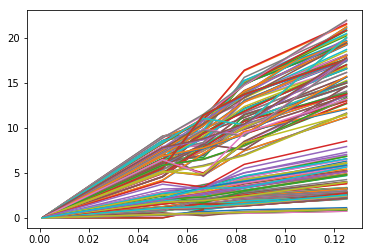

In [450]:
def visualise_box_impact():
    for target, group in r.sort_values('box').groupby('target'):
        ys = np.array(group.energies.values.tolist()).T
        if len(ys.shape) == 3:
            ys = ys[0]
        xs = group['box'].values
        for row in ys:
            plt.plot(1/xs, row - row[-1])
visualise_box_impact()

26.06233081644683


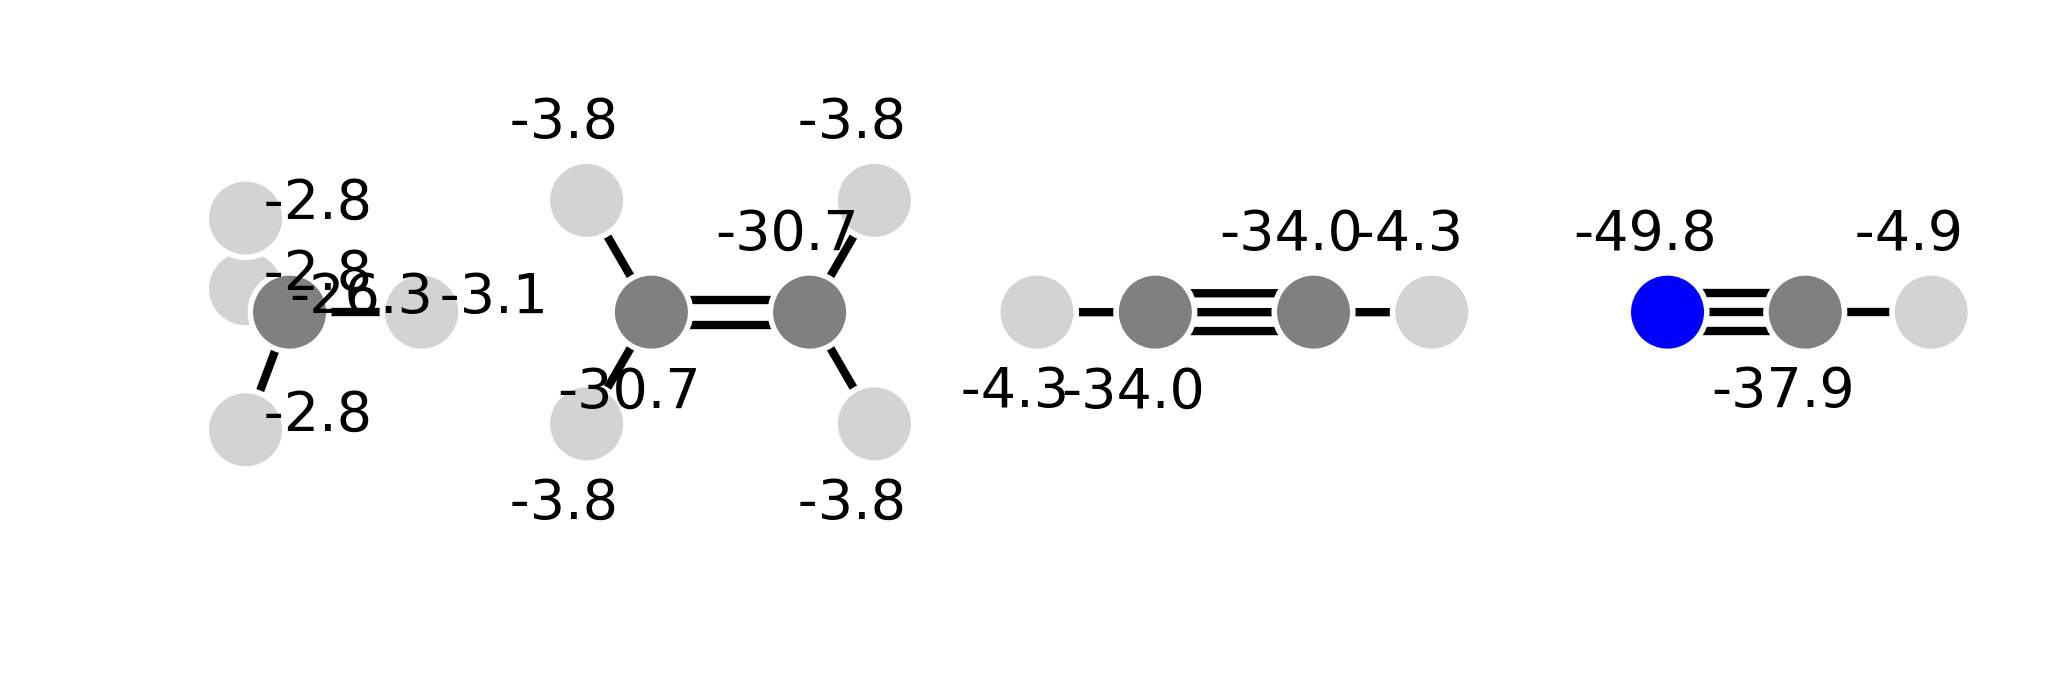

In [564]:
def draw_spn():
    def draw_mol(coords, zs, cog, bonds):
        coords += cog - coords.mean(axis=0)
    
        axs.scatter(coords[:, 0], coords[:, 1],edgecolors=[outlinecolors[_] for _ in zs], c=[colors[_] for _ in zs], s=200)
        def draw_bond(a, b, order):
            if order == 2:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.2
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
            if order == 3:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.3
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
            if order == 1:
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
        #for aidx in range(c.natoms):
        #    axs.text(c.coordinates[aidx, 0], c.coordinates[aidx, 1], str(aidx))

        for afrom, ato, aorder in bonds:
            draw_bond(afrom, ato, aorder)       
        
        
    f, axs = plt.subplots(1, 1, dpi=400)
    axs.set_aspect('equal')
    colors = {6: 'grey', 1: 'lightgrey', 7: 'blue', 8: 'red'}
    outlinecolors = {6: 'white', 1: 'white', 7: 'white', 8: 'white'}
    
    plottotal=True
    
    #methane
    coords = c.iloc[16].coords
    zs = c.iloc[16].zs
    draw_mol(coords, zs, (0., 0., 0.), [(0, 4, 1), (1, 4, 1), (2, 4, 1), (3, 4, 1)])
    
    target = 'methane'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0], coords[aidx, 1], '%5.1f' % ann[aidx])
        
    #ethylene
    coords = c.iloc[90].coords
    zs = c.iloc[90].zs
    rot, _ = sst.Rotation.match_vectors([[0,1,0], [1,0,0]], [coords[0] - coords[1], coords[0] - coords[2]])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (7., 0., 0.), [(0, 4, 1), (1, 4, 1), (2, 5, 1), (3, 5, 1), (4, 5, 2)])
    
    target = 'ethylene'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    # acetylene
    coords = c.iloc[79].coords
    zs = c.iloc[79].zs
    h = coords[2] - coords[1]
    rot, _ = sst.Rotation.match_vectors([[1,1,0], [1,-1,0]], [coords[0] - coords[1], h])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (15., 0., 0.), [(0, 2, 1), (1, 3, 1), (2, 3, 3)])
    
    target = 'acetylene'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    # HCN
    coords = c.iloc[76].coords
    zs = c.iloc[76].zs
    h = coords[1] - coords[2]
    rot, _ = sst.Rotation.match_vectors([[1,1,0], [1,-1,0]], [coords[0] - coords[1], h])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (24, 0., 0.), [(0, 1, 1), (1, 2, 3)])
    
    target = 'HCN'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    
    print (coords[0, 0])
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    axs.set_ylim(-4, 4)
    axs.axis('off')
    
    plt.savefig('spn.pdf')
draw_spn()

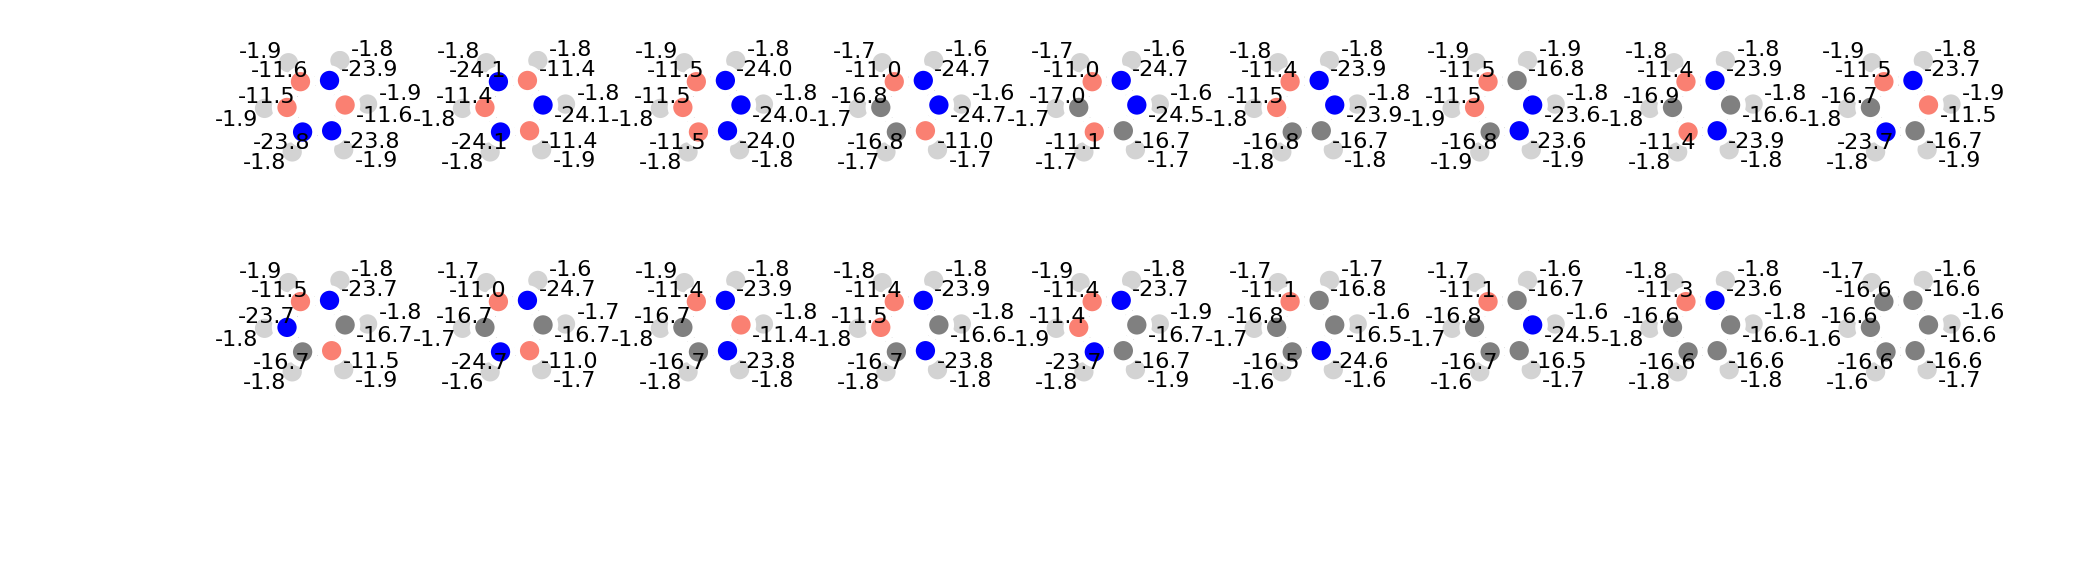

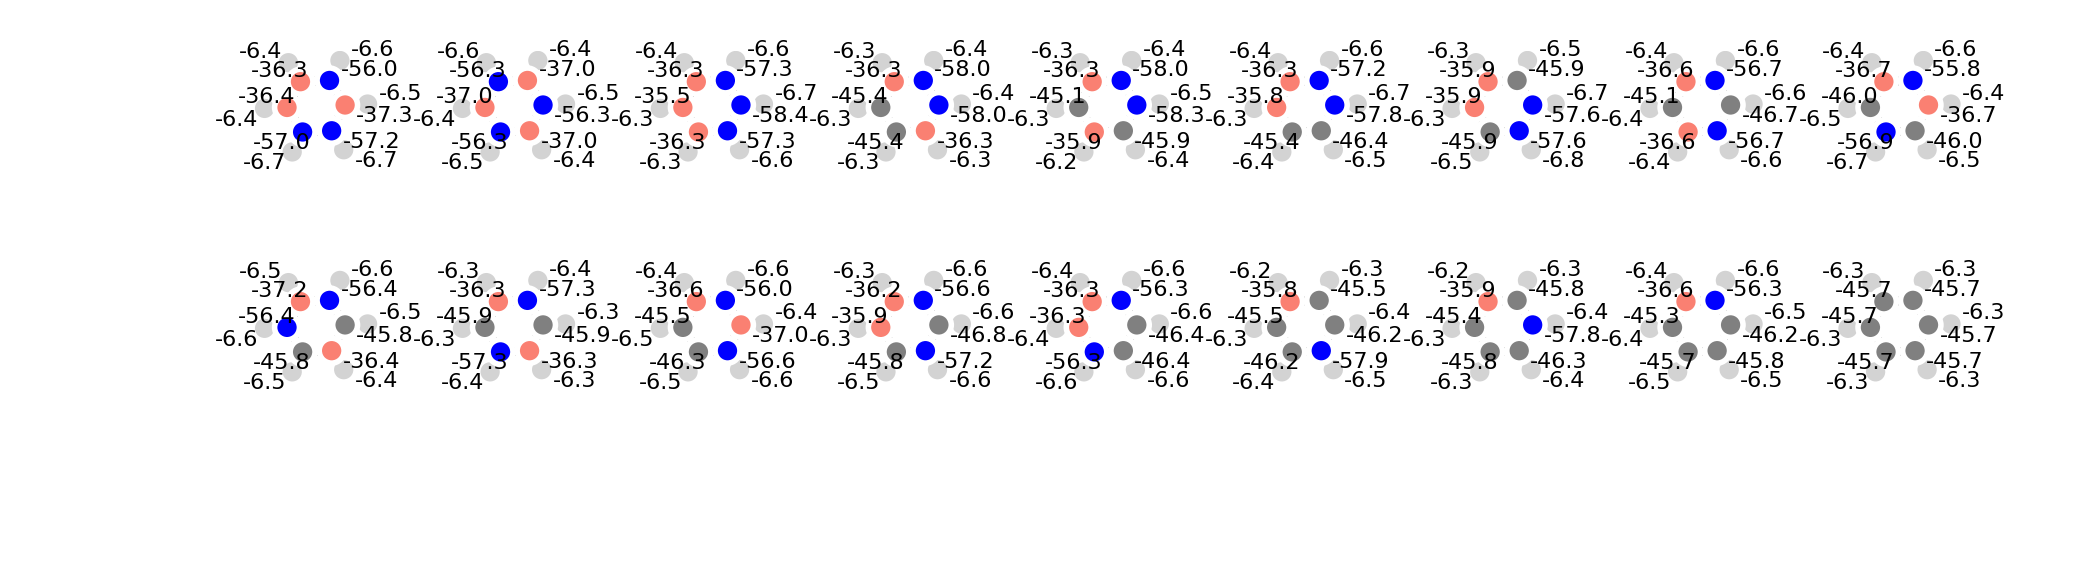

In [735]:
def draw_c6bn(plottotal):
    targets = r[r.numatoms==12].target.unique()
    targets = pd.merge(energy_data,r[r.numatoms==12]).sort_values('energy', ascending=False).target.unique()
    def guess_bonds(qcoords):
        bonds = []
        for atom in range(6):
            ds = np.linalg.norm(qcoords[6:] - qcoords[atom], axis=1)
            bonds.append((atom, 6+np.argmin(ds), 1))
        for atom in range(6):
            ds = np.linalg.norm(qcoords[6:] - qcoords[6+atom], axis=1)
            order = np.argsort(ds)[1:3]
            for e in order:
                bonds.append((atom + 6, e+6, 1))
        return bonds
    def draw_mol(coords, zs, cog, bonds):
        coords += cog - coords.mean(axis=0)
    
        axs.scatter(coords[:, 0], coords[:, 1],edgecolors=[outlinecolors[_] for _ in zs], c=[colors[_] for _ in zs], s=20)
        def draw_bond(a, b, order):
            if order == 2:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.2
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
            if order == 3:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.3
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
            if order == 1:
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
        #for aidx in range(c.natoms):
        #    axs.text(c.coordinates[aidx, 0], c.coordinates[aidx, 1], str(aidx))

        for afrom, ato, aorder in bonds:
            draw_bond(afrom, ato, aorder)       
        
        
    f, axs = plt.subplots(1, 1, dpi=400)
    axs.set_aspect('equal')
    colors = {6: 'grey', 1: 'lightgrey', 7: 'blue', 8: 'red', 5:'salmon'}
    outlinecolors = {6: 'white', 1: 'white', 7: 'white', 8: 'white', 5:'white'}
    
    stats = []
    for tidx, target in enumerate(targets):
        #print(target)
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 1000]
        qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

        coords = qq.coords
        zs = qq.zs
        bonds = guess_bonds(coords)
        draw_mol(coords, zs, (-18*(tidx%9), 20*(tidx//9), 0.), bonds)
        
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 20]
        hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
        shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
        ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
        ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
        if plottotal:
            ann = ann_total
        else:
            ann = ann_elec
        for aidx in range(len(ann)):
            nns = []
            for fa, ta, bo in bonds:
                if fa == aidx:
                    nns.append(ta)
                if ta == aidx:
                    nns.append(fa)
            nns = sorted([zs[_] for _ in set(nns)])
            statkey= (str(zs[aidx]) + '-'+ ''.join(map(str, nns)))
            row = {}
            row['statkey'] = statkey
            row['total'] = ann_total[aidx]
            row['electronic'] = ann_elec[aidx]
            row['target'] = target
            row['bnpairs'] = len([_ for _ in target if _ == '5'])
            stats.append(row)
            
            displ = (coords[aidx, :2] - coords.mean(axis=0)[:2])
            is_horizontal = abs(displ[1])< 0.5
            is_center = np.linalg.norm(displ) < 3
            if displ[0] > 0:
                displ[0] = 1
            else:
                displ[0] = -4.5
            if displ[1] > 0:
                displ[1] = 1
            else:
                displ[1] = -1
            if is_horizontal and is_center:
                displ[1] *= -1
            
            axs.text(coords[aidx, 0]+displ[0], coords[aidx, 1]+displ[1], '%1.1f' % ann[aidx], va='center', fontsize=4)
    
    axs.set_ylim(-8, 25)
    axs.axis('off')
    if plottotal:
        plt.savefig('c6bn-total.pdf')
    else:
        plt.savefig('c6bn-electronic.pdf')
    return pd.DataFrame(stats)
stats = draw_c6bn(True)
stats = draw_c6bn(False)


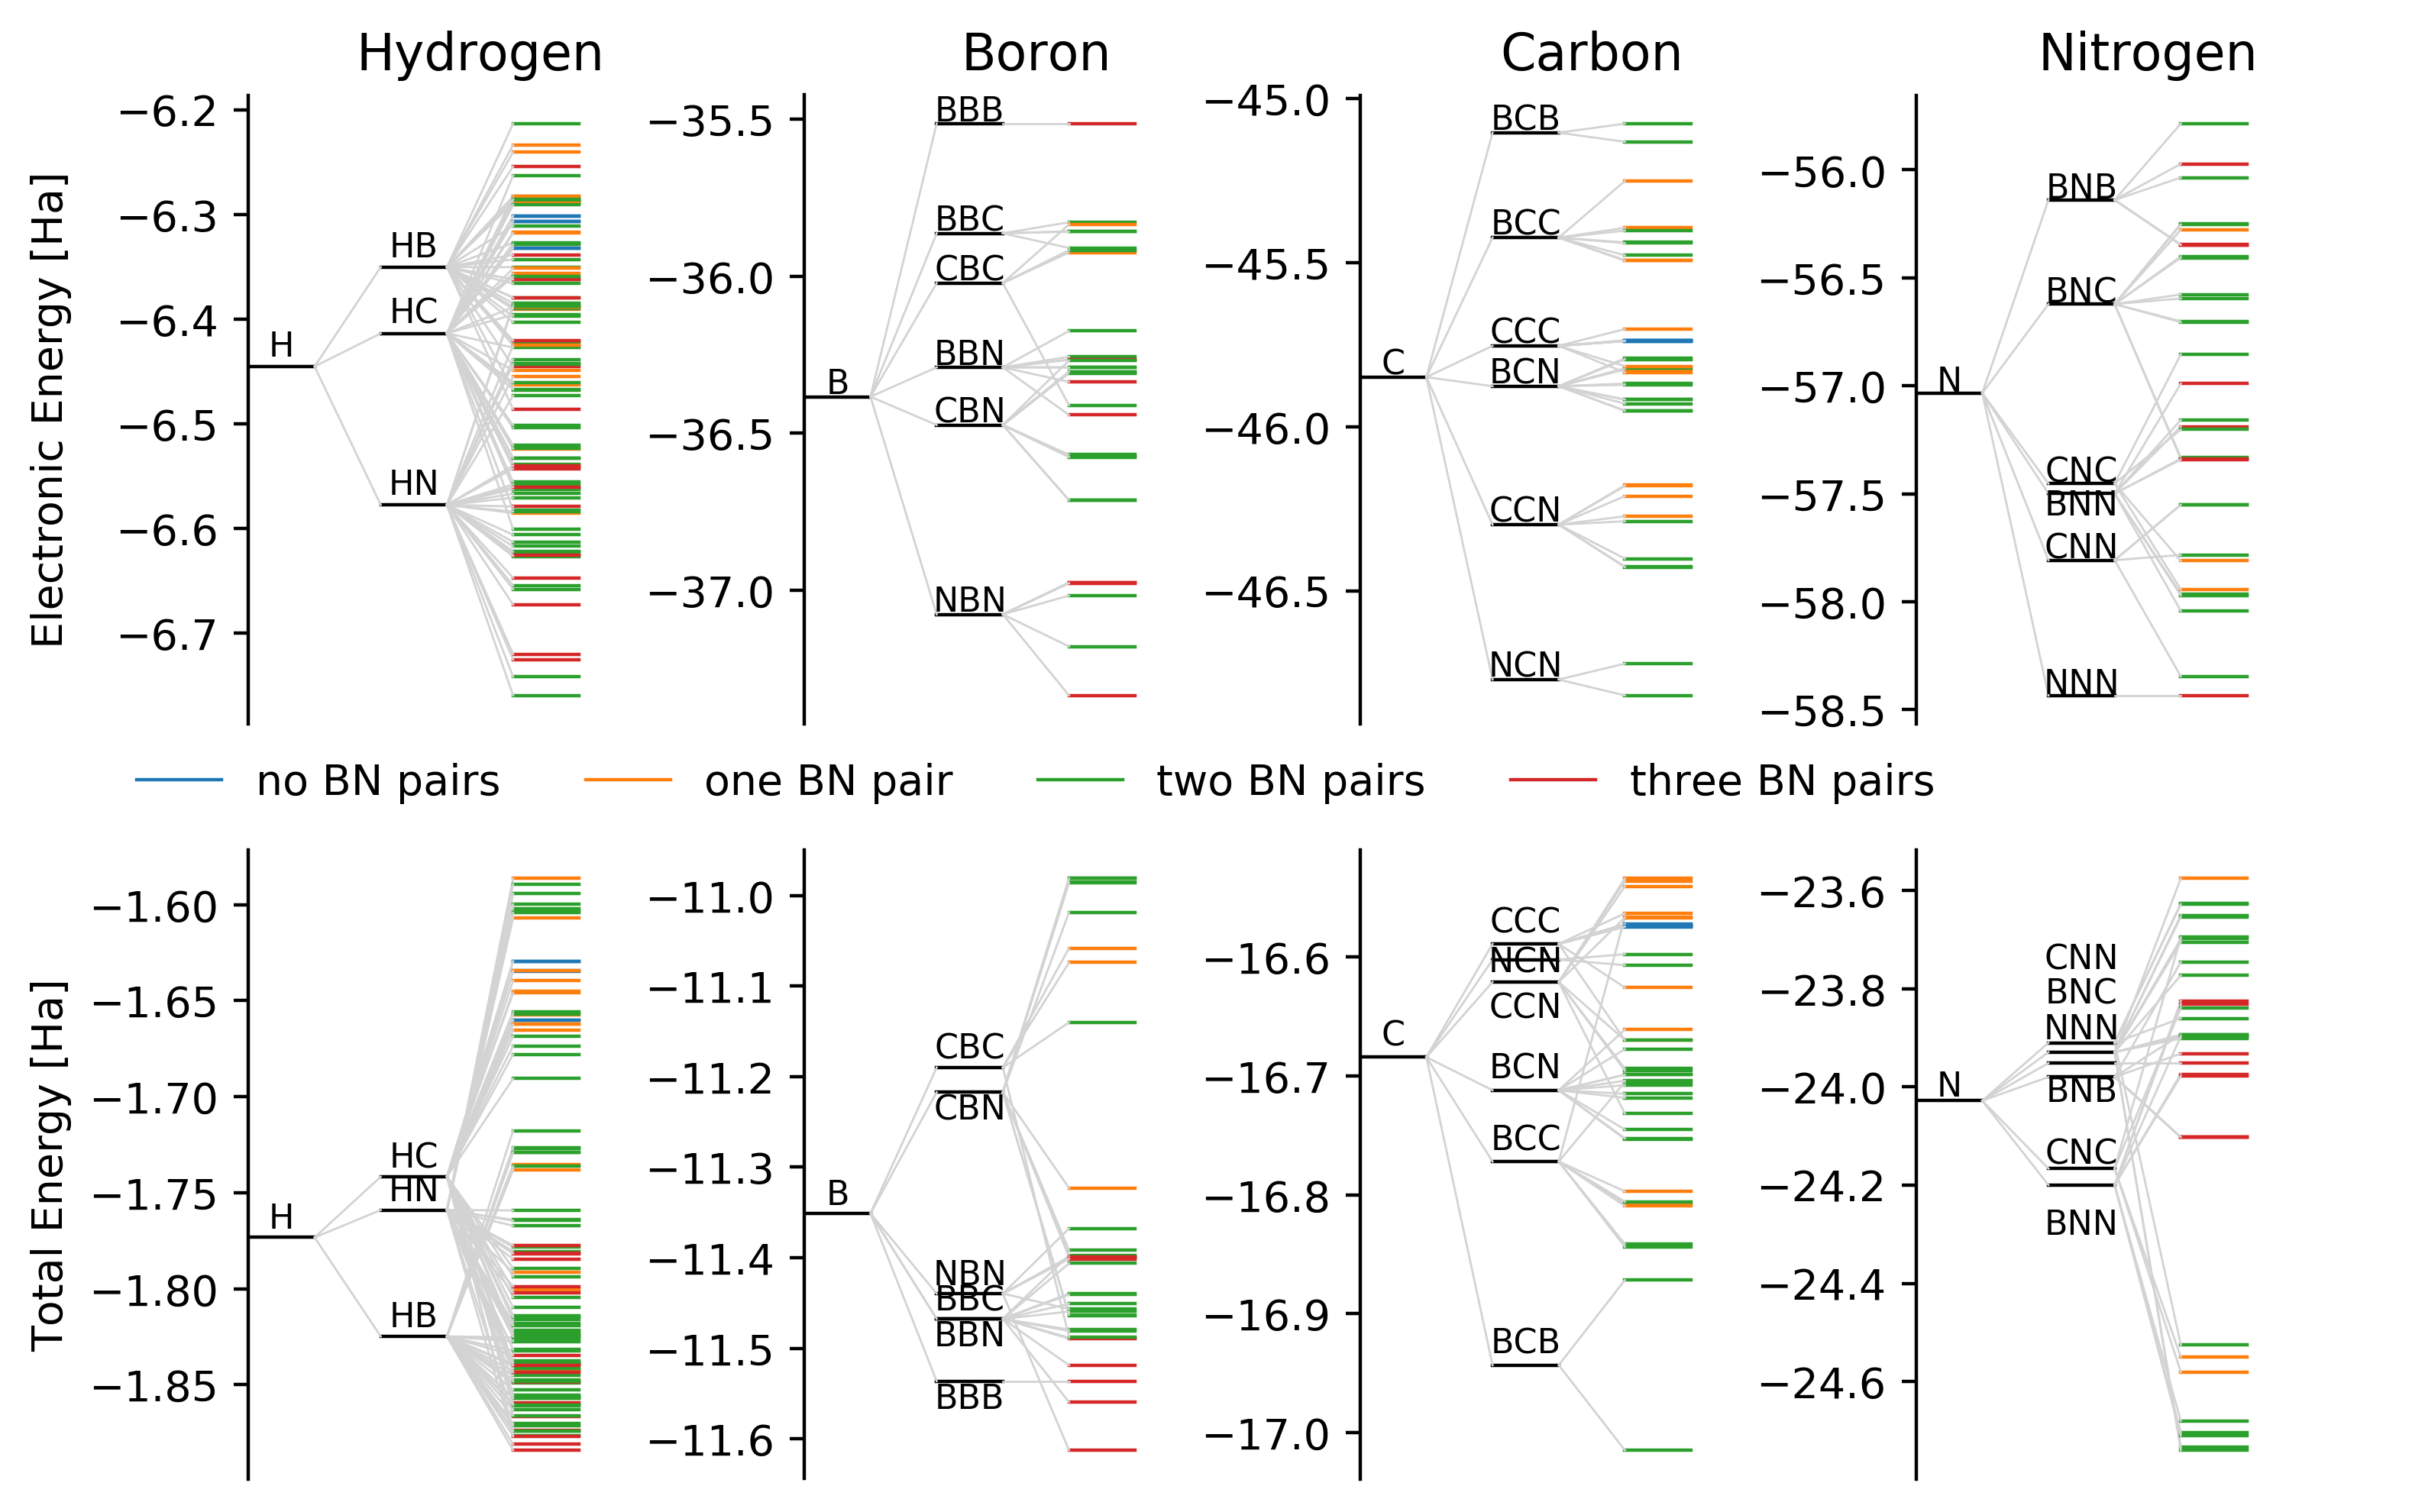

In [761]:
def statsplot():
    plt.rc('font', size=10)
    lookup = {'H': 1, 'B': 5, 'C': 6, 'N': 7}
    rlookup = {1:'H', 5:'B', 6:'C', 7:'N'}
    
    def pretty_label(label):
        if len(label) < 3: return label
        if len(label) == 3:
            return {'1-5': 'HB', '1-6': 'HC', '1-7':'HN'}[label]
        this = rlookup[int(label[0])]
        nn1 = rlookup[int(label[-2])]
        nn2 = rlookup[int(label[-1])]
        return '%s%s%s' % (nn1, this, nn2)
        
    def draw_bar(ax, x, y, width, label, color):
        shift = 0.01
        if ax == axtH:
            shift = 0.005
        if label in ('7-157',) :
            shift = -0.1
        if label in ('5-167', '5-157', '5-155') and ax == axtB:
            shift = -0.03
        if pretty_label(label) == 'NCN' and ax == axtC:
            shift = -0.01
        if pretty_label(label) == 'CCN' and ax == axtC:
            shift = -0.03
        if ax == axtN:
            if pretty_label(label) == 'CNN':
                shift = 0.15
            if pretty_label(label) == 'BNC':
                shift = 0.10
            if pretty_label(label) == 'NNN':
                shift = 0.05
            if pretty_label(label) == 'BNB':
                shift = -0.05
        ax.text(x+0.5, y+shift, pretty_label(label), fontsize=8, color='black', ha='center')
        
        return ax.plot((x, x+width), (y, y), color=color, lw=0.8)
    
    def connect_bars(ax, x, y1, y2, width):
        ax.plot((x, x+width), (y1, y2), color='lightgrey', lw=0.5)
        
    f, axs = plt.subplots(2, 4, dpi=400, figsize=(9, 6), sharex=True)
    
    axs1, axs2 = axs
    axeH, axeB, axeC, axeN = axs1
    axtH, axtB, axtC, axtN = axs2
    
    axeH.set_title('Hydrogen')
    axeB.set_title('Boron')
    axeC.set_title('Carbon')
    axeN.set_title('Nitrogen')
    axeH.set_ylabel('Electronic Energy [Ha]')
    axtH.set_ylabel('Total Energy [Ha]')
    
    legend_handles = {}
    for kind in 'HBCN':
        axe = locals()['axe' + kind]
        axt = locals()['axt' + kind]
        
        # layout
        for ax in (axe, axt):
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            ax.set_xlim(-1, 6)
        
        subset = stats[stats.statkey.str.startswith(str(lookup[kind]))]
        draw_bar(axe, -1, subset.electronic.mean(), 1, kind, 'black')
        draw_bar(axt, -1, subset.total.mean(), 1, kind, 'black')
            
        for name, group in subset.groupby('statkey'):
            draw_bar(axe, 1, group.electronic.mean(), 1, name, 'black')
            connect_bars(axe, 0, subset.electronic.mean(), group.electronic.mean(), 1)
            draw_bar(axt, 1, group.total.mean(), 1, name, 'black')
            connect_bars(axt, 0, subset.total.mean(), group.total.mean(), 1)
            for ridx, row in group.iterrows():
                draw_bar(axe, 3, row.electronic, 1, '', 'C' + str(row['bnpairs']))
                connect_bars(axe, 2, group.electronic.mean(), row.electronic, 1)
                legend_handles[row['bnpairs']] = draw_bar(axt, 3, row.total, 1, '', 'C' + str(row['bnpairs']))
                connect_bars(axt, 2, group.total.mean(), row.total, 1)
    
    # legend
    labels = ['no BN pairs', 'one BN pair', 'two BN pairs', 'three BN pairs']
    handles = [legend_handles[_][0] for _ in (0, 1, 2, 3)]
    axtB.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(0, 0, 1, 1.2), frameon=False)
    
    f.align_ylabels([axeH, axtH])
    plt.savefig('statsplot.pdf')
statsplot()

-42.9
-42.9
-0.6
-0.6
-54.1
-32.1
10.9
-12.2
-70.9
-24.9
21.6
-23.0


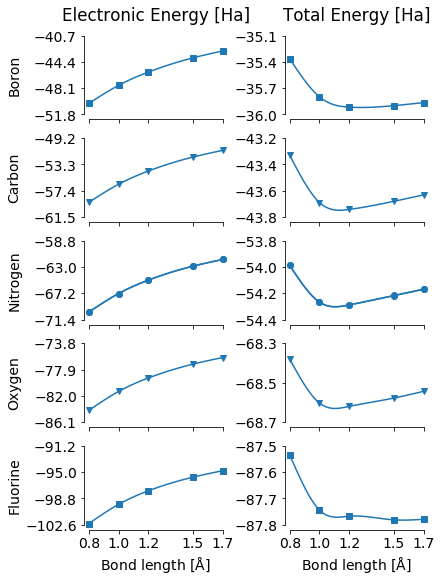

In [785]:
def dimer_plot(box):
    # absurd data from N2 ref
    abs_xs = np.array([ 1.  ,  1.15,  1.3 ,  1.45,  1.6 ,  1.75,  1.9 ,  2.05,  2.2 , 2.35,  2.5 ,  3.  ,  3.5 ,  4.  ,  4.5 ,  5.  , 10.  ])
    abs_N_electronic = np.array([-24.02473527, -23.17638984, -22.43366905, -21.80231526,
       -21.26856024, -20.81594705, -20.42986986, -20.09834239,
       -19.81174485, -19.56238946, -19.34409185, -18.78721306,
       -18.43387238, -18.1748885 , -17.97312386, -17.79926335,
       -17.01783812]) 
    abs_C_electronic = np.array([-24.02473527, -23.17638984, -22.43366905, -21.80231526,
           -21.26856024, -20.81594705, -20.42986986, -20.09834239,
           -19.81174485, -19.56238946, -19.34409185, -18.78721306,
           -18.43387238, -18.1748885 , -17.97312386, -17.79926335,
           -17.01783812]) 
    abs_O_electronic = np.array([-26.79533852, -26.05048184, -25.40047737, -24.85185206,
           -24.39238488, -24.00706644, -23.68231954, -23.40685838,
           -23.17155117, -22.96908218, -22.79360611, -22.35485197,
           -22.09612662, -21.91333717, -21.7500009 , -21.62008187,
           -21.01354589]) 
    abs_B_electronic = np.array([-22.74769835, -21.86007793, -21.08179524, -20.41938276,
           -19.85901311, -19.38361325, -18.97782982, -18.62902937,
           -18.32707455, -18.06387764, -17.83296438, -17.23822061,
           -16.84762785, -16.56836524, -16.35162364, -16.17723178,
           -15.38473126]) 
    abs_F_electronic = np.array([-28.29253286, -27.61017914, -27.01501388, -26.51491964,
           -26.09892793, -25.75279561, -25.46342339, -25.2198784 ,
           -25.01333225, -24.83673903, -24.68450048, -24.304154  ,
           -24.06477363, -23.88130938, -23.72211511, -23.58752767,
           -22.97894659]) 
    abs_N_total = np.array([-52.27239378, -53.2483942 , -53.82858494, -54.16513165,
           -54.35260399, -54.44883423, -54.4893356 , -54.49611534,
           -54.48293268, -54.45844632, -54.4281027 , -54.32649377,
           -54.26998987, -54.23531911, -54.21043457, -54.1633712 ,
           -54.12387292])
    abs_C_total = np.array([-28.74765851, -30.50678697, -31.77953128, -32.70764398,
           -33.39654375, -33.91860147, -34.32262364, -34.64167538,
           -34.89846055, -35.10882281, -35.28401085, -35.70594738,
           -35.97897463, -36.18543061, -36.34842182, -36.46410785,
           -37.15603479])
    abs_O_total = np.array([-79.5677323 , -79.73365865, -79.6136777 , -79.3618113 ,
           -79.05748887, -78.74161496, -78.43481304, -78.14687615,
           -77.88175657, -77.64029446, -77.42170881, -76.84801241,
           -76.50897363, -76.27365628, -76.07154658, -75.88345307,
           -75.18741881])
    abs_B_total = np.array([ -8.7780249 , -11.26782876, -13.20370451, -14.70578167,
           -15.88461671, -16.82449362, -17.58635145, -18.21373698,
           -18.73797402, -19.18187696, -19.56230994, -20.51682633,
           -21.14621247, -21.59862368, -21.95166701, -22.20905209,
           -23.55447202])
    abs_F_total = np.array([-110.85848732, -110.20834291, -109.39732274, -108.57438646,
           -107.80049878, -107.09731133, -106.46885788, -105.91155252,
           -105.41878761, -104.98311029, -104.59723965, -103.60157555,
           -102.97101543, -102.49797293, -102.09914452, -101.73857099,
           -100.28182773])

    plt.rc('font', size=14)
    f, axs = plt.subplots(5, 2, figsize=(6, 9), sharex=True)
    pane = {'N2': (2,2), 'CO': (3, 1), 'BF': (4, 0)}
    lookup = {7:'N', 8:'O', 6:'C', 9:'F', 5:'B'}
    for tidx, target in enumerate('N2 CO BF'.split()):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == box].sort_values('target')
        ds = np.array([float(_.split('-')[-1]) for _ in q.target.values])
        zs = q.zs.values[0]
        hasE = -np.array(q.energies.tolist()).sum(axis=1) + np.array(q.enn.tolist()).sum(axis=1)
        shift = (q.energy.values - hasE) / sum(q.zs.iloc[0])
        ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.outer(shift, np.array(q.zs.iloc[0])))
        ann_elec = (-np.array(q.energies.tolist()) + np.outer(shift, np.array(q.zs.iloc[0])))
        for column in (0, 1):
            if column == 1:
                ann = ann_total
            else:
                ann = ann_elec
            if target != 'N2d':
                mask = np.where((ds < 2.0) & (ds != 1.22))[0]
            else:
                mask = np.where((ds < 2.0))[0]
            for site in (0,1):
                if column == 1:
                    absurd = locals()['abs_%s_total' % lookup[zs[site]]]
                else:
                    absurd = locals()['abs_%s_electronic' % lookup[zs[site]]]
                xs = ds[mask]
                ys = ann[:, site][mask]
                xss = np.linspace(min(xs), max(xs), 50)
                spl = CubicSpline(xs, ys, bc_type='natural')
                ax = axs[pane[target][site], column]
                # layout
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                # content
                try:
                    root = [_ for _ in spl.derivative().roots() if 0.8 < _ and _ < 1.4][0]
                    #ax.axvline(root)
                    #print (lookup[zs[site]], root)
                except:
                    pass
                yss = spl(xss)
                
                #print ('D', ys)
                tpos = guess_ticks(ys)
                #print (tpos)
                ax.set_yticks(tpos)
                ax.set_ylim(tpos[0], tpos[-1])
                marker = 'o'
                if lookup[zs[site]] in 'BF':
                    marker = 's'
                if lookup[zs[site]] in 'CO':
                    marker = 'v'
                line, = ax.plot(xs, ys, marker, label='%s' % lookup[zs[site]], color='C0')
                line.set_clip_on(False)
                shift = np.round(- absurd[:5].mean() + ys.mean(), 1)
                print (shift)
                #aplot, = ax.plot(abs_xs, absurd +shift, '--', color='C1')
                #ax.legend([line,aplot], ['UFE', 'N2, %+1.1f Ha' % shift], frameon=False, fontsize=10)
                ax.plot(xss, yss, color='C0')
    
    axs[0, 0].set_ylabel('Boron')
    axs[1, 0].set_ylabel('Carbon')
    axs[2, 0].set_ylabel('Nitrogen')
    axs[3, 0].set_ylabel('Oxygen')
    axs[4, 0].set_ylabel('Fluorine')
    axs[-1, 0].set_xlabel('Bond length [$\mathrm{\AA}$]')
    axs[-1, 1].set_xlabel('Bond length [$\mathrm{\AA}$]')
    axs[0, 0].set_title('Electronic Energy [Ha]', pad=15.)
    axs[0, 1].set_title('Total Energy [Ha]', pad=15.)
    
    for col in (0, 1):
        for row in range(5):
            axs[row, col].set_xlim(.8, 1.7)
            axs[row, col].set_xticks([0.8, 1.0, 1.2, 1.5, 1.7])

            if row != 40:
                axs[row, col].spines['bottom'].set_position(('outward', 5))
                axs[row, col].spines['bottom'].set_smart_bounds(True)
            
            axs[row, col].spines['left'].set_position(('outward', 5))
            axs[row, col].spines['left'].set_smart_bounds(True)
    
    f.align_ylabels(axs[:, 0])
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    plt.savefig('dimer.pdf', bbox_inches='tight')
dimer_plot(15)

In [648]:
def guess_ticks(vals):
    vals= np.array(vals)
    vrange = vals.max() - vals.min()
    for spacing in (2, 3, 4, 3):
        step = np.round(vrange/spacing, 1)
        start = int(np.floor(vals.min()/step)) * step
        stop = int(np.ceil(vals.max()/step)) * step
        ret = np.arange(start, stop + step/2, step)
        if len(ret) == 5:
            ret = ret[0::2]
        return ret

In [632]:
guess_ticks([-53.98726088, -54.26767977, -54.28872625, -54.21802797 ,-54.16971329])

array([-54.4, -54.2, -54. , -53.8])

In [762]:
class CUBE(object):
  def __init__(self, fname):
    f = open(fname, 'r')
    for i in range(2): f.readline() # echo comment
    tkns = f.readline().split() # number of atoms included in the file followed by the position of the origin of the volumetric data
    self.natoms = int(tkns[0])
    self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NX = int(tkns[0])
    self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NY = int(tkns[0])
    self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NZ = int(tkns[0])
    self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    self.atoms = []
    for i in range(self.natoms):
      tkns = f.readline().split()
      self.atoms.append([tkns[0], tkns[2], tkns[3], tkns[4]])
    self.data = np.zeros((self.NX,self.NY,self.NZ))
    i=0
    for s in f:
      for v in s.split():
        self.data[i//(self.NY*self.NZ), (i//self.NZ)%self.NY, i%self.NZ] = float(v)
        i+=1
    if i != self.NX*self.NY*self.NZ: raise NameError("FSCK!")


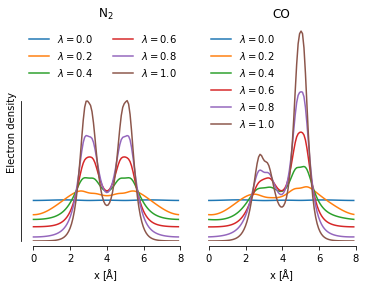

In [784]:
def denplot():
    ff, axs = plt.subplots(1, 2)
    axN2, axCO = axs
    
    for mol in ('N2 CO'.split()):
        ax = locals()['ax%s' % mol]
        for mix in ('0.00 0.20 0.40 0.60 0.80 1.00'.split()):
            cube = CUBE('%s/%s/DENSITY.cube' % (mol, mix))
            q = cube.data.sum(axis=1).sum(axis=1)
            xs = cube.X[0]*np.arange(len(q))
            spl = CubicSpline(xs, q, bc_type='natural')
            xss = np.linspace(min(xs), max(xs), 100)
            yss = spl(xss)
            ax.plot(xss/1.88973, yss, label='$\lambda=$%s' % mix[:-1])
        ncol = 2
        if mol == 'CO':
            ncol = 1
    
        ax.legend(frameon=False, ncol=ncol)
        ax.set_xlabel(r'x [$\mathrm{\AA}$]')
        ax.set_yticks([])
        ax.set_ylim(0, 80)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['bottom'].set_smart_bounds(True)
        if mol == 'N2':
            ax.set_title('N$_2$')
        else:
            ax.set_title('CO')
            ax.spines['left'].set_visible(False)
        
    axN2.set_ylabel(r'Electron density')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)
    plt.savefig('densgrow.pdf', bbox_inches='tight')
denplot()